<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ViLT/Fine_tuning_ViLT_for_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers

In [ ]:
import json

# Opening JSON file
f = open('/content/drive/MyDrive/OpenEnded_abstract_v002_val2017_questions.json')

# Return JSON object as dictionary
data_questions = json.load(f)
print(data_questions.keys())

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])


In [ ]:
questions = data_questions['questions']
print("Number of questions:", len(questions))

Number of questions: 11328


In [ ]:
questions[0]

{'image_id': 28940, 'question': 'Is it daylight?', 'question_id': 289402}

In [ ]:
import re
from typing import Optional

filename_re = re.compile(r".*(\d{12})\.((jpg)|(png))")

# source: https://github.com/allenai/allennlp-models/blob/a36aed540e605c4293c25f73d6674071ca9edfc3/allennlp_models/vision/dataset_readers/vqav2.py#L141
def id_from_filename(filename: str) -> Optional[int]:
    match = filename_re.fullmatch(filename)
    if match is None:
        return None
    return int(match.group(1))

In [ ]:
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm

# root at which all images are stored
root = '/content/drive/MyDrive/scene_img_abstract_v002_binary_val2017-20240517T114432Z-001/scene_img_abstract_v002_binary_val2017/output_directory'
file_names = [f for f in tqdm(listdir(root)) if isfile(join(root, f))]

  0%|          | 0/10729 [00:00<?, ?it/s]

In [ ]:
id_from_filename('COCO_val2014_000000501080.jpg')

501080

In [ ]:
filename_to_id = {root + "/" + file: id_from_filename(file) for file in file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

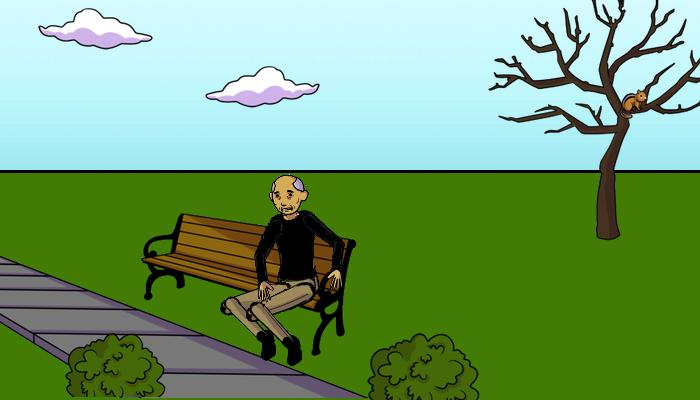

In [ ]:
from PIL import Image

path = id_to_filename[questions[0]['image_id']]
image = Image.open(path).convert("RGB")
image

In [ ]:
import json

# Read annotations
f = open('/content/drive/MyDrive/abstract_v002_val2017_annotations.json')

# Return JSON object as dictionary
data_annotations = json.load(f)
print(data_annotations.keys())

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])


In [ ]:
annotations = data_annotations['annotations']

In [ ]:
print("Number of annotations:", len(annotations))

Number of annotations: 11328


In [ ]:
annotations[0]

{'question_type': 'is it',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 28940,
 'answer_type': 'yes/no',
 'question_id': 289402}

In [ ]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

In [ ]:
from tqdm.notebook import tqdm

def get_score(count: int) -> float:
    return min(1.0, count / 3)

for annotation in tqdm(annotations):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = get_score(answer_count[answer])
        scores.append(score)
    annotation['labels'] = labels
    annotation['scores'] = scores

  0%|          | 0/11328 [00:00<?, ?it/s]

In [ ]:
annotations[0]

{'question_type': 'is it',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 28940,
 'answer_type': 'yes/no',
 'question_id': 289402,
 'labels': [3],
 'scores': [1.0]}

In [ ]:
labels = annotations[0]['labels']
print([config.id2label[label] for label in labels])

['yes']


In [ ]:
scores = annotations[0]['scores']
print(scores)

[1.0]


In [ ]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = Image.open(id_to_filename[annotation['image_id']])
        text = questions['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        scores = annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(config.id2label))
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets

        return encoding

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

dataset = VQADataset(questions=questions[:100],
                     annotations=annotations[:100],
                     processor=processor)

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:

dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [ ]:
processor.decode(dataset[0]['input_ids'])

'[CLS] is it daylight? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()

In [ ]:
if isinstance(labels, int):
    labels = [labels]
else:
    labels = labels.tolist()

[config.id2label[label] for label in labels]

['yes']

In [ ]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

In [ ]:

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, annotations, questions, id_to_filename):
        self.annotations = annotations
        self.questions = questions
        self.id_to_filename = id_to_filename

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        questions = self.questions[idx]

        # Check if the image ID exists in the dictionary
        if annotation['image_id'] not in self.id_to_filename:
            raise KeyError(f"Missing image ID: {annotation['image_id']}")

        image = Image.open(self.id_to_filename[annotation['image_id']])
        text = questions['question']

        return {'image': image, 'text': text, 'labels': annotation['labels']}

    def __len__(self):
        return len(self.annotations)

# Ensure that the id_to_filename dictionary contains all image IDs
for annotation in annotations:
    if annotation['image_id'] not in id_to_filename:
        id_to_filename[annotation['image_id']] = "path/to/content/drive/MyDrive/scene_img_abstract_v002_binary_val2017-20240517T114432Z-001/scene_img_abstract_v002_binary_val2017/output_directory"

In [ ]:
# Create the DataLoader
train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)


In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 352, 608])
pixel_mask torch.Size([4, 352, 608])
labels torch.Size([4, 3129])


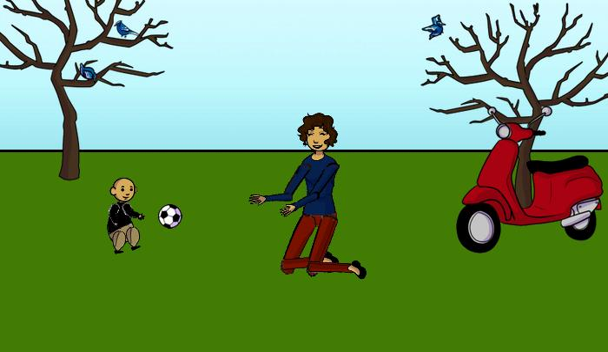

In [ ]:
from PIL import Image
import numpy as np

image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
processor.decode(batch["input_ids"][batch_idx])

'[CLS] is the woman crying? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
labels = torch.nonzero(batch['labels'][batch_idx]).squeeze().tolist()

labels_list = labels.tolist()
[config.id2label[label] for label in labels_list]

In [ ]:
label_names = [config.id2label[label] for label in labels]


[config.id2label[label] for label in labels]

TypeError: 'int' object is not iterable

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(50):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 2272.020263671875
Loss: 2222.428466796875
Loss: 2162.036376953125
Loss: 2130.4541015625
Loss: 2109.787353515625
Loss: 2017.1966552734375
Loss: 1985.2930908203125
Loss: 1909.6600341796875
Loss: 1863.5018310546875
Loss: 1814.67724609375
Loss: 1855.3480224609375
Loss: 1717.6199951171875
Loss: 1672.066650390625
Loss: 1605.6497802734375
Loss: 1570.0166015625
Loss: 1525.9237060546875
Loss: 1478.340576171875
Loss: 1435.9774169921875
Loss: 1384.312744140625
Loss: 1332.459228515625
Loss: 1291.9637451171875
Loss: 1249.46044921875
Loss: 1207.3726806640625
Loss: 1163.5703125
Loss: 1129.95654296875
Epoch: 1


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 1092.4969482421875
Loss: 1056.9801025390625
Loss: 1019.735107421875
Loss: 989.9360961914062
Loss: 955.2091674804688
Loss: 925.3597412109375
Loss: 894.0288696289062
Loss: 864.7992553710938
Loss: 836.0265502929688
Loss: 809.3523559570312
Loss: 784.5928344726562
Loss: 760.0667114257812
Loss: 734.18115234375
Loss: 714.3917236328125
Loss: 688.3194580078125
Loss: 666.9205322265625
Loss: 646.1694946289062
Loss: 625.9266967773438
Loss: 606.7509155273438
Loss: 589.0233764648438
Loss: 570.6973266601562
Loss: 553.532470703125
Loss: 536.7162475585938
Loss: 520.855712890625
Loss: 505.2410583496094
Epoch: 2


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 490.1225891113281
Loss: 476.2627868652344
Loss: 462.9485778808594
Loss: 450.19384765625
Loss: 437.4289245605469
Loss: 426.1122131347656
Loss: 414.8406066894531
Loss: 403.5829162597656
Loss: 392.6844787597656
Loss: 382.16094970703125
Loss: 372.29925537109375
Loss: 363.0914001464844
Loss: 353.59393310546875
Loss: 344.8272705078125
Loss: 336.6581726074219
Loss: 328.19989013671875
Loss: 320.78009033203125
Loss: 313.0785217285156
Loss: 305.87628173828125
Loss: 298.66387939453125
Loss: 292.0719909667969
Loss: 285.32177734375
Loss: 279.4111633300781
Loss: 272.92462158203125
Loss: 267.1934509277344
Epoch: 3


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 261.5800476074219
Loss: 256.0565185546875
Loss: 250.9825897216797
Loss: 245.8643035888672
Loss: 240.75588989257812
Loss: 235.92762756347656
Loss: 231.25643920898438
Loss: 226.78675842285156
Loss: 222.50965881347656
Loss: 218.17947387695312
Loss: 214.21722412109375
Loss: 209.96568298339844
Loss: 206.41049194335938
Loss: 202.46266174316406
Loss: 199.21835327148438
Loss: 195.61431884765625
Loss: 192.09487915039062
Loss: 188.951171875
Loss: 185.80282592773438
Loss: 182.68515014648438
Loss: 179.91403198242188
Loss: 176.60067749023438
Loss: 173.5074005126953
Loss: 171.046875
Loss: 168.0799560546875
Epoch: 4


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 165.39126586914062
Loss: 162.938720703125
Loss: 160.79129028320312
Loss: 157.85931396484375
Loss: 155.62855529785156
Loss: 153.12860107421875
Loss: 151.09466552734375
Loss: 148.7834930419922
Loss: 146.63047790527344
Loss: 144.51968383789062
Loss: 142.41693115234375
Loss: 140.57037353515625
Loss: 138.13674926757812
Loss: 136.7963104248047
Loss: 134.77352905273438
Loss: 133.07415771484375
Loss: 131.03964233398438
Loss: 129.19522094726562
Loss: 127.56988525390625
Loss: 125.96157836914062
Loss: 124.21187591552734
Loss: 122.60456848144531
Loss: 120.83138275146484
Loss: 119.32231903076172
Loss: 117.86318969726562
Epoch: 5


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 116.50463104248047
Loss: 115.41178894042969
Loss: 113.78141784667969
Loss: 112.221923828125
Loss: 110.97150421142578
Loss: 109.60370635986328
Loss: 108.163818359375
Loss: 106.95553588867188
Loss: 105.70136260986328
Loss: 104.38211059570312
Loss: 103.5309829711914
Loss: 102.20159912109375
Loss: 100.650146484375
Loss: 100.15996551513672
Loss: 98.55097961425781
Loss: 97.58062744140625
Loss: 96.15148162841797
Loss: 95.379150390625
Loss: 94.1513900756836
Loss: 93.38455200195312
Loss: 92.36187744140625
Loss: 91.38182067871094
Loss: 90.38147735595703
Loss: 89.54322814941406
Loss: 88.45001220703125
Epoch: 6


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 87.67965698242188
Loss: 86.58761596679688
Loss: 85.55903625488281
Loss: 84.82075500488281
Loss: 83.94841003417969
Loss: 83.25062561035156
Loss: 82.22879028320312
Loss: 81.50389099121094
Loss: 80.68457794189453
Loss: 80.03646850585938
Loss: 79.34273529052734
Loss: 78.24454498291016
Loss: 77.77064514160156
Loss: 76.8109359741211
Loss: 76.54473876953125
Loss: 75.220458984375
Loss: 74.73295593261719
Loss: 73.97425842285156
Loss: 73.21944427490234
Loss: 72.53740692138672
Loss: 71.77360534667969
Loss: 71.17349243164062
Loss: 70.6583480834961
Loss: 69.92143249511719
Loss: 69.69696807861328
Epoch: 7


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 68.58641052246094
Loss: 67.81940460205078
Loss: 67.42743682861328
Loss: 66.98966979980469
Loss: 66.44966888427734
Loss: 66.01483917236328
Loss: 65.53881072998047
Loss: 64.49771118164062
Loss: 63.952274322509766
Loss: 63.440284729003906
Loss: 62.9582633972168
Loss: 62.8840217590332
Loss: 62.04021072387695
Loss: 61.442081451416016
Loss: 61.0577278137207
Loss: 60.46584701538086
Loss: 60.04906463623047
Loss: 59.36802291870117
Loss: 58.88746643066406
Loss: 58.403587341308594
Loss: 57.90028381347656
Loss: 57.401336669921875
Loss: 57.088138580322266
Loss: 56.573734283447266
Loss: 56.042144775390625
Epoch: 8


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 55.715641021728516
Loss: 55.42867660522461
Loss: 55.00755310058594
Loss: 54.27781295776367
Loss: 54.06260299682617
Loss: 53.63569259643555
Loss: 53.43318557739258
Loss: 52.772186279296875
Loss: 52.320613861083984
Loss: 51.82242965698242
Loss: 51.52891159057617
Loss: 51.16712188720703
Loss: 50.73777770996094
Loss: 50.28569793701172
Loss: 50.025360107421875
Loss: 49.56694412231445
Loss: 49.420921325683594
Loss: 49.06663131713867
Loss: 48.47053146362305
Loss: 48.15107727050781
Loss: 47.91507339477539
Loss: 47.87596893310547
Loss: 47.23081588745117
Loss: 47.38204574584961
Loss: 46.76106643676758
Epoch: 9


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 46.19794464111328
Loss: 45.95267105102539
Loss: 45.64945983886719
Loss: 45.26730728149414
Loss: 44.95370864868164
Loss: 44.631080627441406
Loss: 44.49557113647461
Loss: 44.34849548339844
Loss: 43.73186492919922
Loss: 43.44357681274414
Loss: 43.32484436035156
Loss: 42.83590316772461
Loss: 42.43296432495117
Loss: 42.402923583984375
Loss: 42.26575469970703
Loss: 41.65637969970703
Loss: 42.222679138183594
Loss: 41.32516860961914
Loss: 41.14657211303711
Loss: 40.86912155151367
Loss: 40.46398162841797
Loss: 39.916717529296875
Loss: 40.04267120361328
Loss: 39.4415168762207
Loss: 39.327144622802734
Epoch: 10


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 39.21782302856445
Loss: 38.91059112548828
Loss: 38.72561264038086
Loss: 38.87235641479492
Loss: 38.151336669921875
Loss: 37.85261917114258
Loss: 37.831939697265625
Loss: 37.44839859008789
Loss: 37.307647705078125
Loss: 37.08919143676758
Loss: 37.219661712646484
Loss: 36.57763671875
Loss: 36.425994873046875
Loss: 36.17207717895508
Loss: 36.15830993652344
Loss: 35.63331985473633
Loss: 35.86260223388672
Loss: 35.836490631103516
Loss: 35.1197624206543
Loss: 34.7119255065918
Loss: 34.70168685913086
Loss: 34.317970275878906
Loss: 34.37559127807617
Loss: 33.90644073486328
Loss: 33.84032440185547
Epoch: 11


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 33.56380081176758
Loss: 33.58232879638672
Loss: 33.6276741027832
Loss: 33.10110855102539
Loss: 32.940975189208984
Loss: 32.97651290893555
Loss: 32.67479705810547
Loss: 32.679588317871094
Loss: 32.099578857421875
Loss: 32.234683990478516
Loss: 31.965396881103516
Loss: 31.514522552490234
Loss: 31.383644104003906
Loss: 31.612585067749023
Loss: 31.509288787841797
Loss: 31.1099910736084
Loss: 30.791004180908203
Loss: 30.58522605895996
Loss: 30.449249267578125
Loss: 30.542142868041992
Loss: 30.025524139404297
Loss: 29.94407844543457
Loss: 30.148849487304688
Loss: 29.9178409576416
Loss: 29.39995574951172
Epoch: 12


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 29.385631561279297
Loss: 29.535755157470703
Loss: 29.561315536499023
Loss: 28.768596649169922
Loss: 28.679149627685547
Loss: 28.534671783447266
Loss: 28.482913970947266
Loss: 28.752988815307617
Loss: 28.043682098388672
Loss: 28.17715835571289
Loss: 28.06153678894043
Loss: 27.888792037963867
Loss: 27.49428939819336
Loss: 27.50543785095215
Loss: 27.376724243164062
Loss: 27.399906158447266
Loss: 27.01289176940918
Loss: 26.97095489501953
Loss: 26.90717124938965
Loss: 26.945850372314453
Loss: 26.359882354736328
Loss: 26.661731719970703
Loss: 26.172210693359375
Loss: 26.066972732543945
Loss: 26.048282623291016
Epoch: 13


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 26.19057846069336
Loss: 26.301748275756836
Loss: 25.534189224243164
Loss: 25.80079460144043
Loss: 25.28398323059082
Loss: 25.413986206054688
Loss: 25.123029708862305
Loss: 25.116241455078125
Loss: 24.90202522277832
Loss: 24.844215393066406
Loss: 24.959171295166016
Loss: 24.731483459472656
Loss: 24.358522415161133
Loss: 24.326679229736328
Loss: 24.13306427001953
Loss: 23.990032196044922
Loss: 24.027334213256836
Loss: 24.0062313079834
Loss: 23.79103660583496
Loss: 23.657806396484375
Loss: 23.602773666381836
Loss: 23.336872100830078
Loss: 23.820512771606445
Loss: 23.342655181884766
Loss: 23.332717895507812
Epoch: 14


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 23.281532287597656
Loss: 22.785316467285156
Loss: 23.212600708007812
Loss: 22.789003372192383
Loss: 22.787639617919922
Loss: 22.62919044494629
Loss: 22.39260482788086
Loss: 22.329402923583984
Loss: 22.193456649780273
Loss: 22.089828491210938
Loss: 21.915857315063477
Loss: 21.839256286621094
Loss: 21.58394432067871
Loss: 21.853191375732422
Loss: 21.896259307861328
Loss: 21.425275802612305
Loss: 21.50093650817871
Loss: 21.230915069580078
Loss: 21.388216018676758
Loss: 21.49095344543457
Loss: 21.460796356201172
Loss: 21.438125610351562
Loss: 21.10062026977539
Loss: 20.919418334960938
Loss: 21.123046875
Epoch: 15


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 20.723926544189453
Loss: 20.81203269958496
Loss: 20.183473587036133
Loss: 20.571332931518555
Loss: 20.328948974609375
Loss: 20.354520797729492
Loss: 19.9494571685791
Loss: 20.453683853149414
Loss: 20.549819946289062
Loss: 20.287832260131836
Loss: 19.691740036010742
Loss: 19.67909812927246
Loss: 19.83767318725586
Loss: 19.55451202392578
Loss: 19.40420150756836
Loss: 19.811649322509766
Loss: 19.216920852661133
Loss: 19.390316009521484
Loss: 19.37569808959961
Loss: 19.178977966308594
Loss: 19.07576560974121
Loss: 19.16025733947754
Loss: 18.8291015625
Loss: 18.960084915161133
Loss: 18.862245559692383
Epoch: 16


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 18.770261764526367
Loss: 18.607234954833984
Loss: 18.42975425720215
Loss: 18.32089614868164
Loss: 18.239953994750977
Loss: 18.327409744262695
Loss: 18.31412696838379
Loss: 18.187259674072266
Loss: 18.20951271057129
Loss: 18.123300552368164
Loss: 17.959678649902344
Loss: 18.22115707397461
Loss: 18.261259078979492
Loss: 17.942848205566406
Loss: 18.09040641784668
Loss: 18.16158103942871
Loss: 17.51902198791504
Loss: 18.05038833618164
Loss: 17.50983238220215
Loss: 17.360923767089844
Loss: 17.306522369384766
Loss: 17.08124542236328
Loss: 17.351184844970703
Loss: 17.274097442626953
Loss: 16.98297119140625
Epoch: 17


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 17.013057708740234
Loss: 17.32475471496582
Loss: 16.984588623046875
Loss: 16.824966430664062
Loss: 16.594715118408203
Loss: 16.768596649169922
Loss: 17.1768856048584
Loss: 16.601627349853516
Loss: 16.52704620361328
Loss: 16.480422973632812
Loss: 16.28319549560547
Loss: 16.08731460571289
Loss: 16.291318893432617
Loss: 16.395723342895508
Loss: 16.28928565979004
Loss: 16.53223991394043
Loss: 16.118267059326172
Loss: 15.920262336730957
Loss: 15.86410140991211
Loss: 16.051799774169922
Loss: 15.897343635559082
Loss: 15.879149436950684
Loss: 15.641801834106445
Loss: 15.726099014282227
Loss: 15.932422637939453
Epoch: 18


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 15.632547378540039
Loss: 15.476259231567383
Loss: 15.742012023925781
Loss: 15.227821350097656
Loss: 15.836013793945312
Loss: 15.716158866882324
Loss: 15.293684959411621
Loss: 15.313920974731445
Loss: 15.384754180908203
Loss: 15.184591293334961
Loss: 15.499150276184082
Loss: 14.950974464416504
Loss: 14.996639251708984
Loss: 14.983160018920898
Loss: 14.679503440856934
Loss: 14.764283180236816
Loss: 14.719817161560059
Loss: 14.663993835449219
Loss: 14.6481351852417
Loss: 14.726875305175781
Loss: 14.590846061706543
Loss: 14.462841033935547
Loss: 14.371280670166016
Loss: 14.319050788879395
Loss: 14.424217224121094
Epoch: 19


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 14.390254974365234
Loss: 14.355520248413086
Loss: 14.738489151000977
Loss: 13.9551420211792
Loss: 14.149894714355469
Loss: 14.114654541015625
Loss: 14.052813529968262
Loss: 14.00574779510498
Loss: 14.060334205627441
Loss: 14.007392883300781
Loss: 14.244178771972656
Loss: 13.882312774658203
Loss: 13.877403259277344
Loss: 14.255708694458008
Loss: 13.636784553527832
Loss: 13.675823211669922
Loss: 13.585601806640625
Loss: 13.94566535949707
Loss: 13.539426803588867
Loss: 13.505456924438477
Loss: 13.45068359375
Loss: 13.330808639526367
Loss: 13.409358024597168
Loss: 12.991689682006836
Loss: 13.283256530761719
Epoch: 20


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 13.196398735046387
Loss: 13.06561279296875
Loss: 13.134573936462402
Loss: 12.940751075744629
Loss: 13.078812599182129
Loss: 13.27876091003418
Loss: 12.953832626342773
Loss: 12.892343521118164
Loss: 12.921991348266602
Loss: 12.769841194152832
Loss: 13.029248237609863
Loss: 12.840513229370117
Loss: 12.65788745880127
Loss: 12.92331600189209
Loss: 12.72965145111084
Loss: 13.089859962463379
Loss: 13.063194274902344
Loss: 13.344076156616211
Loss: 12.572259902954102
Loss: 12.623380661010742
Loss: 12.343439102172852
Loss: 12.264030456542969
Loss: 13.008244514465332
Loss: 12.224141120910645
Loss: 12.226139068603516
Epoch: 21


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 12.080492973327637
Loss: 12.215999603271484
Loss: 12.117804527282715
Loss: 12.204270362854004
Loss: 12.069924354553223
Loss: 12.080763816833496
Loss: 12.097557067871094
Loss: 12.571837425231934
Loss: 12.068131446838379
Loss: 11.873815536499023
Loss: 11.73155403137207
Loss: 11.795138359069824
Loss: 11.813848495483398
Loss: 11.522756576538086
Loss: 12.268970489501953
Loss: 11.922676086425781
Loss: 11.848573684692383
Loss: 11.753878593444824
Loss: 11.774311065673828
Loss: 11.708477973937988
Loss: 12.056299209594727
Loss: 11.506837844848633
Loss: 11.607711791992188
Loss: 12.08409309387207
Loss: 11.661643981933594
Epoch: 22


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 11.383527755737305
Loss: 11.392391204833984
Loss: 11.824362754821777
Loss: 11.16982650756836
Loss: 11.737237930297852
Loss: 11.159846305847168
Loss: 11.381842613220215
Loss: 11.192140579223633
Loss: 11.161335945129395
Loss: 11.928061485290527
Loss: 11.18681526184082
Loss: 11.053037643432617
Loss: 11.198345184326172
Loss: 11.017743110656738
Loss: 10.88034439086914
Loss: 10.995849609375
Loss: 10.955405235290527
Loss: 11.021843910217285
Loss: 10.765145301818848
Loss: 11.00139331817627
Loss: 10.849798202514648
Loss: 10.942821502685547
Loss: 10.822402954101562
Loss: 10.689619064331055
Loss: 10.605622291564941
Epoch: 23


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 10.721626281738281
Loss: 10.713827133178711
Loss: 10.641033172607422
Loss: 10.766600608825684
Loss: 10.468023300170898
Loss: 10.920888900756836
Loss: 10.65877628326416
Loss: 10.944924354553223
Loss: 10.454113006591797
Loss: 10.240806579589844
Loss: 10.268656730651855
Loss: 10.225818634033203
Loss: 10.317486763000488
Loss: 10.48459529876709
Loss: 10.426895141601562
Loss: 10.259507179260254
Loss: 10.347391128540039
Loss: 10.538265228271484
Loss: 9.943594932556152
Loss: 10.788451194763184
Loss: 10.224474906921387
Loss: 10.251782417297363
Loss: 10.291421890258789
Loss: 10.17161750793457
Loss: 10.106830596923828
Epoch: 24


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 9.979866027832031
Loss: 10.079438209533691
Loss: 9.888361930847168
Loss: 10.019405364990234
Loss: 10.391199111938477
Loss: 10.207499504089355
Loss: 9.981426239013672
Loss: 10.07171630859375
Loss: 9.90731143951416
Loss: 9.817737579345703
Loss: 9.877704620361328
Loss: 10.241928100585938
Loss: 9.702313423156738
Loss: 10.009746551513672
Loss: 9.669231414794922
Loss: 9.650256156921387
Loss: 9.523645401000977
Loss: 9.738412857055664
Loss: 9.516440391540527
Loss: 9.483224868774414
Loss: 9.53283977508545
Loss: 9.60954475402832
Loss: 9.267096519470215
Loss: 9.576761245727539
Loss: 9.399392127990723
Epoch: 25


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 9.968417167663574
Loss: 9.384622573852539
Loss: 9.8762845993042
Loss: 9.578889846801758
Loss: 9.467899322509766
Loss: 9.277865409851074
Loss: 9.339629173278809
Loss: 9.249397277832031
Loss: 9.2642822265625
Loss: 9.302245140075684
Loss: 9.302230834960938
Loss: 9.181488037109375
Loss: 9.042131423950195
Loss: 9.276872634887695
Loss: 8.997842788696289
Loss: 9.131221771240234
Loss: 9.002079963684082
Loss: 9.1519775390625
Loss: 9.00304126739502
Loss: 8.905818939208984
Loss: 9.436178207397461
Loss: 8.942523956298828
Loss: 9.390046119689941
Loss: 8.741477012634277
Loss: 8.882987976074219
Epoch: 26


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 8.83985424041748
Loss: 9.01981258392334
Loss: 8.648411750793457
Loss: 8.639140129089355
Loss: 8.547616004943848
Loss: 9.040153503417969
Loss: 8.70572280883789
Loss: 9.319228172302246
Loss: 9.004800796508789
Loss: 8.507903099060059
Loss: 8.846328735351562
Loss: 8.896575927734375
Loss: 8.863029479980469
Loss: 9.604269027709961
Loss: 8.6572904586792
Loss: 8.784173965454102
Loss: 8.32626724243164
Loss: 8.607523918151855
Loss: 8.415143013000488
Loss: 8.281292915344238
Loss: 8.869484901428223
Loss: 8.395051002502441
Loss: 8.436827659606934
Loss: 8.471646308898926
Loss: 8.85976791381836
Epoch: 27


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 8.286870002746582
Loss: 8.21397590637207
Loss: 8.433692932128906
Loss: 8.343478202819824
Loss: 8.343564987182617
Loss: 8.26375675201416
Loss: 8.447641372680664
Loss: 8.42619514465332
Loss: 7.974277019500732
Loss: 8.132521629333496
Loss: 8.379546165466309
Loss: 8.188072204589844
Loss: 8.66926383972168
Loss: 8.207274436950684
Loss: 8.090863227844238
Loss: 8.0066556930542
Loss: 8.707648277282715
Loss: 8.215133666992188
Loss: 8.217367172241211
Loss: 8.631250381469727
Loss: 8.40185832977295
Loss: 7.941422939300537
Loss: 7.930753707885742
Loss: 8.133461952209473
Loss: 7.986196041107178
Epoch: 28


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 7.793121814727783
Loss: 7.954164505004883
Loss: 7.998179912567139
Loss: 7.8687357902526855
Loss: 8.503796577453613
Loss: 8.281344413757324
Loss: 7.784692764282227
Loss: 7.739166736602783
Loss: 7.657568454742432
Loss: 7.910122871398926
Loss: 7.856832981109619
Loss: 7.734723091125488
Loss: 7.6783833503723145
Loss: 8.340567588806152
Loss: 7.730693817138672
Loss: 7.908278942108154
Loss: 7.867883205413818
Loss: 7.688112735748291
Loss: 7.830567359924316
Loss: 7.845433712005615
Loss: 7.515957355499268
Loss: 7.5483880043029785
Loss: 7.762806415557861
Loss: 7.605770111083984
Loss: 7.833344459533691
Epoch: 29


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 7.342251777648926
Loss: 7.599985122680664
Loss: 7.62576961517334
Loss: 7.513368129730225
Loss: 7.587313175201416
Loss: 7.406126022338867
Loss: 7.531308174133301
Loss: 7.501890182495117
Loss: 7.1873602867126465
Loss: 7.393397331237793
Loss: 7.192356109619141
Loss: 7.49238395690918
Loss: 7.902276515960693
Loss: 7.851442813873291
Loss: 7.5296478271484375
Loss: 7.446140766143799
Loss: 7.567329406738281
Loss: 7.182815074920654
Loss: 7.350269794464111
Loss: 7.395592212677002
Loss: 7.217991352081299
Loss: 7.818173885345459
Loss: 7.049555778503418
Loss: 7.67025089263916
Loss: 7.314510822296143
Epoch: 30


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 7.445713043212891
Loss: 7.165239334106445
Loss: 7.054759979248047
Loss: 7.088107585906982
Loss: 7.344342231750488
Loss: 7.129796028137207
Loss: 7.022421836853027
Loss: 7.186642169952393
Loss: 7.017908573150635
Loss: 7.362004280090332
Loss: 7.007352828979492
Loss: 7.550076007843018
Loss: 7.205835819244385
Loss: 7.057156085968018
Loss: 6.909694194793701
Loss: 6.896720886230469
Loss: 7.160114765167236
Loss: 6.7769060134887695
Loss: 7.102124214172363
Loss: 6.9041056632995605
Loss: 6.96356725692749
Loss: 7.40903902053833
Loss: 6.971240043640137
Loss: 6.7908735275268555
Loss: 7.430482387542725
Epoch: 31


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.715192794799805
Loss: 6.7385573387146
Loss: 6.9217119216918945
Loss: 6.819021701812744
Loss: 6.95358419418335
Loss: 6.752766132354736
Loss: 6.945198059082031
Loss: 6.874124526977539
Loss: 6.629947662353516
Loss: 6.767584800720215
Loss: 6.768479824066162
Loss: 6.457287311553955
Loss: 7.317629814147949
Loss: 7.064394474029541
Loss: 6.566899299621582
Loss: 6.8332648277282715
Loss: 6.643894672393799
Loss: 6.650399684906006
Loss: 7.232880115509033
Loss: 6.6925435066223145
Loss: 6.7864670753479
Loss: 6.989110946655273
Loss: 6.652759075164795
Loss: 6.6139607429504395
Loss: 6.578242778778076
Epoch: 32


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.432007312774658
Loss: 6.256167888641357
Loss: 6.381323337554932
Loss: 6.72196626663208
Loss: 6.712451934814453
Loss: 6.373269081115723
Loss: 6.648954391479492
Loss: 6.644382476806641
Loss: 6.441007137298584
Loss: 6.611571311950684
Loss: 6.405410289764404
Loss: 6.262134552001953
Loss: 6.939101219177246
Loss: 6.88214635848999
Loss: 6.422374248504639
Loss: 6.452789306640625
Loss: 6.4371843338012695
Loss: 6.515982627868652
Loss: 6.737486362457275
Loss: 6.17404317855835
Loss: 6.265750885009766
Loss: 6.46717643737793
Loss: 6.913720607757568
Loss: 6.289978981018066
Loss: 6.25191068649292
Epoch: 33


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.266817569732666
Loss: 6.324013710021973
Loss: 6.307680130004883
Loss: 6.144591808319092
Loss: 6.810731410980225
Loss: 6.121219158172607
Loss: 6.239891529083252
Loss: 6.182120323181152
Loss: 6.081241607666016
Loss: 6.088406085968018
Loss: 6.062192916870117
Loss: 6.750269889831543
Loss: 6.667243957519531
Loss: 5.9580607414245605
Loss: 6.297692775726318
Loss: 6.073362350463867
Loss: 6.632125377655029
Loss: 6.1590423583984375
Loss: 6.2222113609313965
Loss: 6.057724952697754
Loss: 6.182623863220215
Loss: 6.028233051300049
Loss: 6.0862040519714355
Loss: 5.99114990234375
Loss: 6.246170520782471
Epoch: 34


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 6.027095794677734
Loss: 5.967212677001953
Loss: 5.93134880065918
Loss: 6.483529090881348
Loss: 6.171195030212402
Loss: 6.029240608215332
Loss: 6.2096943855285645
Loss: 5.9629411697387695
Loss: 5.982935905456543
Loss: 5.942172050476074
Loss: 5.775528430938721
Loss: 6.014428615570068
Loss: 6.020007133483887
Loss: 6.336790561676025
Loss: 5.7362518310546875
Loss: 5.922128200531006
Loss: 5.917508602142334
Loss: 5.744667053222656
Loss: 6.336227893829346
Loss: 6.143595218658447
Loss: 5.820697784423828
Loss: 5.973227500915527
Loss: 5.938559532165527
Loss: 5.885616779327393
Loss: 5.764793395996094
Epoch: 35


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 5.743384838104248
Loss: 5.682614803314209
Loss: 5.653243064880371
Loss: 5.84176778793335
Loss: 5.7256693840026855
Loss: 5.645834445953369
Loss: 5.60181999206543
Loss: 6.008194923400879
Loss: 5.650672912597656
Loss: 6.246776103973389
Loss: 5.797457695007324
Loss: 5.729210376739502
Loss: 5.641501426696777
Loss: 5.456244468688965
Loss: 5.912205696105957
Loss: 5.431909561157227
Loss: 6.065006256103516
Loss: 5.521151065826416
Loss: 5.512415885925293
Loss: 5.710479736328125
Loss: 5.766900539398193
Loss: 5.882076740264893
Loss: 6.187153339385986
Loss: 6.075582504272461
Loss: 5.602319240570068
Epoch: 36


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 5.471381664276123
Loss: 5.670165061950684
Loss: 6.412038803100586
Loss: 5.468776702880859
Loss: 5.674763202667236
Loss: 5.472527980804443
Loss: 5.549030303955078
Loss: 5.701327323913574
Loss: 5.459120750427246
Loss: 5.343597412109375
Loss: 5.547811508178711
Loss: 5.475163459777832
Loss: 5.409997463226318
Loss: 5.519073486328125
Loss: 5.461423873901367
Loss: 5.368030548095703
Loss: 5.34896183013916
Loss: 5.671445846557617
Loss: 6.154529094696045
Loss: 5.56003475189209
Loss: 5.609463691711426
Loss: 5.48518180847168
Loss: 5.127326488494873
Loss: 5.375179290771484
Loss: 5.374704837799072
Epoch: 37


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 5.364038467407227
Loss: 5.3000593185424805
Loss: 5.407429218292236
Loss: 5.44715690612793
Loss: 5.337374687194824
Loss: 5.310453414916992
Loss: 5.375009059906006
Loss: 5.869110107421875
Loss: 5.4399824142456055
Loss: 5.749401569366455
Loss: 5.277998447418213
Loss: 5.332953929901123
Loss: 5.3225836753845215
Loss: 5.408134937286377
Loss: 5.229426383972168
Loss: 5.244010925292969
Loss: 5.419139385223389
Loss: 5.204807758331299
Loss: 5.0738043785095215
Loss: 5.665651321411133
Loss: 5.235113143920898
Loss: 5.251173496246338
Loss: 5.334638595581055
Loss: 5.252230644226074
Loss: 5.050017356872559
Epoch: 38


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 5.148240089416504
Loss: 5.126980304718018
Loss: 5.269301891326904
Loss: 5.220776081085205
Loss: 5.0453081130981445
Loss: 5.287902355194092
Loss: 5.165779113769531
Loss: 5.235793590545654
Loss: 5.030577182769775
Loss: 5.027448654174805
Loss: 5.257249355316162
Loss: 5.054064750671387
Loss: 5.4620137214660645
Loss: 5.021312713623047
Loss: 5.524899005889893
Loss: 5.034272193908691
Loss: 4.959001541137695
Loss: 4.967710971832275
Loss: 4.9063897132873535
Loss: 5.648555278778076
Loss: 5.603370666503906
Loss: 4.886260986328125
Loss: 5.035161972045898
Loss: 5.082774639129639
Loss: 5.145042419433594
Epoch: 39


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.905181407928467
Loss: 4.946439266204834
Loss: 4.987231731414795
Loss: 5.126347064971924
Loss: 5.095231533050537
Loss: 4.800953388214111
Loss: 4.7843780517578125
Loss: 5.547775745391846
Loss: 4.928822994232178
Loss: 4.992934703826904
Loss: 5.039137840270996
Loss: 4.790855407714844
Loss: 4.721343040466309
Loss: 4.901285171508789
Loss: 5.48005485534668
Loss: 4.9313178062438965
Loss: 5.316166877746582
Loss: 5.033926486968994
Loss: 4.828618049621582
Loss: 4.779506206512451
Loss: 5.39717960357666
Loss: 4.965333938598633
Loss: 4.6522064208984375
Loss: 4.873685359954834
Loss: 4.810917854309082
Epoch: 40


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.941655158996582
Loss: 4.860569477081299
Loss: 4.9061665534973145
Loss: 4.6318230628967285
Loss: 4.879322528839111
Loss: 4.937378406524658
Loss: 5.2811055183410645
Loss: 4.914681434631348
Loss: 4.767630100250244
Loss: 4.745404243469238
Loss: 4.766305923461914
Loss: 4.903675079345703
Loss: 4.7072649002075195
Loss: 4.736998081207275
Loss: 5.159806728363037
Loss: 4.7674560546875
Loss: 4.845713138580322
Loss: 4.818506717681885
Loss: 4.602248668670654
Loss: 5.201555252075195
Loss: 5.064759731292725
Loss: 4.530571460723877
Loss: 4.56984806060791
Loss: 4.669005870819092
Loss: 4.507299900054932
Epoch: 41


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.752523899078369
Loss: 4.582131385803223
Loss: 5.245240688323975
Loss: 5.277785301208496
Loss: 5.267533302307129
Loss: 4.420520305633545
Loss: 4.696448802947998
Loss: 4.8675079345703125
Loss: 4.68912935256958
Loss: 5.168454647064209
Loss: 4.486385822296143
Loss: 4.655762195587158
Loss: 4.465733528137207
Loss: 4.534766674041748
Loss: 4.734060764312744
Loss: 4.488565444946289
Loss: 4.614667892456055
Loss: 4.674226760864258
Loss: 4.422216415405273
Loss: 4.688878059387207
Loss: 4.490774631500244
Loss: 4.426273822784424
Loss: 4.360305309295654
Loss: 4.632093906402588
Loss: 4.464269638061523
Epoch: 42


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.607300758361816
Loss: 4.7558817863464355
Loss: 4.516513347625732
Loss: 4.534985065460205
Loss: 4.302844047546387
Loss: 4.6487321853637695
Loss: 4.433862686157227
Loss: 4.367064476013184
Loss: 5.019895076751709
Loss: 4.562624931335449
Loss: 4.51786994934082
Loss: 4.29610538482666
Loss: 4.434517860412598
Loss: 4.504319667816162
Loss: 4.961380481719971
Loss: 4.366735458374023
Loss: 4.308535099029541
Loss: 4.407768249511719
Loss: 4.330689907073975
Loss: 5.0862860679626465
Loss: 4.39168119430542
Loss: 4.282700061798096
Loss: 4.458006381988525
Loss: 4.626764297485352
Loss: 4.640644550323486
Epoch: 43


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.537550926208496
Loss: 4.981482982635498
Loss: 4.243602275848389
Loss: 4.509037494659424
Loss: 5.4132890701293945
Loss: 4.319095611572266
Loss: 4.496256351470947
Loss: 4.360833168029785
Loss: 4.3545050621032715
Loss: 4.4772257804870605
Loss: 4.263367176055908
Loss: 4.34273624420166
Loss: 4.288907051086426
Loss: 4.3302998542785645
Loss: 4.59445858001709
Loss: 4.3691606521606445
Loss: 4.1203203201293945
Loss: 4.3109612464904785
Loss: 4.34556770324707
Loss: 4.166080474853516
Loss: 4.236804962158203
Loss: 4.405224323272705
Loss: 4.10688591003418
Loss: 4.305222034454346
Loss: 4.3080058097839355
Epoch: 44


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.085221767425537
Loss: 4.135688781738281
Loss: 4.165830612182617
Loss: 4.423508644104004
Loss: 4.30223274230957
Loss: 4.329753875732422
Loss: 4.529285907745361
Loss: 4.319398403167725
Loss: 4.144991397857666
Loss: 4.047031879425049
Loss: 4.19536828994751
Loss: 4.367040634155273
Loss: 4.611217975616455
Loss: 4.360754489898682
Loss: 4.126034736633301
Loss: 4.72044563293457
Loss: 4.630774021148682
Loss: 4.823789596557617
Loss: 3.9939119815826416
Loss: 4.017953872680664
Loss: 4.284893035888672
Loss: 4.177377700805664
Loss: 3.9294586181640625
Loss: 4.204795837402344
Loss: 4.1456499099731445
Epoch: 45


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.1858062744140625
Loss: 4.2356133460998535
Loss: 3.999756097793579
Loss: 4.13162899017334
Loss: 4.039124011993408
Loss: 3.989380359649658
Loss: 4.275799751281738
Loss: 3.9624037742614746
Loss: 4.513190746307373
Loss: 3.966137409210205
Loss: 4.182498455047607
Loss: 4.534122943878174
Loss: 4.035505294799805
Loss: 4.620685577392578
Loss: 3.9338932037353516
Loss: 4.020341396331787
Loss: 4.240563869476318
Loss: 4.044679641723633
Loss: 4.088329315185547
Loss: 4.196347236633301
Loss: 4.740572452545166
Loss: 4.262092590332031
Loss: 4.090967178344727
Loss: 3.9464571475982666
Loss: 4.201759338378906
Epoch: 46


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.134179592132568
Loss: 3.921375036239624
Loss: 3.9340174198150635
Loss: 4.0865068435668945
Loss: 4.072391510009766
Loss: 3.8851144313812256
Loss: 3.8792080879211426
Loss: 3.898594617843628
Loss: 4.069620132446289
Loss: 4.349897384643555
Loss: 3.9308552742004395
Loss: 4.0193071365356445
Loss: 3.9102768898010254
Loss: 4.511678218841553
Loss: 3.828122138977051
Loss: 4.008854866027832
Loss: 3.8089475631713867
Loss: 3.944725751876831
Loss: 3.947439432144165
Loss: 4.437854290008545
Loss: 4.0390543937683105
Loss: 4.532975196838379
Loss: 3.882554054260254
Loss: 4.206757068634033
Loss: 3.9406049251556396
Epoch: 47


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.333676338195801
Loss: 3.9832024574279785
Loss: 3.702801465988159
Loss: 3.8422861099243164
Loss: 3.773299217224121
Loss: 3.815542697906494
Loss: 3.882498264312744
Loss: 3.9984426498413086
Loss: 4.226071834564209
Loss: 3.88763427734375
Loss: 3.664656162261963
Loss: 3.7850356101989746
Loss: 4.952614784240723
Loss: 4.419799327850342
Loss: 3.778214931488037
Loss: 3.947580099105835
Loss: 4.12449836730957
Loss: 4.107437610626221
Loss: 3.6479129791259766
Loss: 4.006494522094727
Loss: 3.756049871444702
Loss: 3.7057688236236572
Loss: 3.6803786754608154
Loss: 3.942559003829956
Loss: 3.8152084350585938
Epoch: 48


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 4.346249103546143
Loss: 3.7364587783813477
Loss: 3.735703706741333
Loss: 3.6411116123199463
Loss: 3.807476758956909
Loss: 3.648587226867676
Loss: 3.9569361209869385
Loss: 3.843332290649414
Loss: 3.9136853218078613
Loss: 3.8324368000030518
Loss: 3.7809088230133057
Loss: 3.7815561294555664
Loss: 3.6945221424102783
Loss: 3.8758623600006104
Loss: 3.6802587509155273
Loss: 3.4755325317382812
Loss: 4.273747444152832
Loss: 3.8830151557922363
Loss: 3.8463165760040283
Loss: 3.812206268310547
Loss: 4.154669284820557
Loss: 3.530362844467163
Loss: 4.079474449157715
Loss: 3.9096879959106445
Loss: 4.257375240325928
Epoch: 49


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 3.727766275405884
Loss: 3.782215118408203
Loss: 3.691956043243408
Loss: 3.7563345432281494
Loss: 3.7511610984802246
Loss: 3.737260103225708
Loss: 3.6102418899536133
Loss: 4.083844184875488
Loss: 3.6592745780944824
Loss: 3.5760951042175293
Loss: 4.206314563751221
Loss: 3.799360990524292
Loss: 3.7378902435302734
Loss: 3.6521244049072266
Loss: 3.7365925312042236
Loss: 4.243287563323975
Loss: 3.545649528503418
Loss: 3.8045647144317627
Loss: 3.6736576557159424
Loss: 3.7044484615325928
Loss: 3.5732147693634033
Loss: 4.050889015197754
Loss: 3.776937961578369
Loss: 3.482903003692627
Loss: 3.5638182163238525


In [ ]:
model.save_pretrained('/content/drive/MyDrive/newmodel')


In [ ]:
example = dataset[0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
processor.decode(example['input_ids'])

'[CLS] is it daylight? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_classes = torch.sigmoid(logits)

probs, classes = torch.topk(predicted_classes, 5)

for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
  print(prob, model.config.id2label[class_idx])

0.8896201252937317 buoys
0.8349507451057434 1:25
0.8237242698669434 heineken
0.8221096396446228 motel
0.8187292218208313 trunks


In [ ]:
## Load the image
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms





image = Image.open("/content/drive/MyDrive/image.jpg").convert("RGB")
text="What is green object in the image?"
# Preprocess the image
#model =  ViltForQuestionAnswering.from_pretrained('/content/drive/MyDrive/newmodel')
#processor = ViltProcessor.from_pretrained('/content/drive/MyDrive/newmodel')

processor1 = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model1 = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

#preprocess = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
inputs = processor1(image, text, return_tensors="pt")

# # Extract the image embeddings
#image_embeds = processor.image_processor(image)["pixel_values"]

# # Pass the image embeddings to the model
predicted_answer = model1( **inputs)

# image = Image.open(requests.get(url, stream=True).raw)
# text = "How many cats are there?"

#processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
# model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
#encoding = processor(image, text, return_tensors="pt")

# forward pass
#predicted_answer = model(**encoding)

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

In [ ]:
logits = predicted_answer.logits
idx = logits.argmax(-1).item()
print(text)
print("Predicted answer:", model1.config.id2label[idx])

What is green object in the image?
Predicted answer: grapes


In [ ]:
processor1.save_pretrained('/content/drive/MyDrive/finalmodel')
model1.save_pretrained('/content/drive/MyDrive/finalmodel')

In [45]:
from PIL import Image

# len(questions['questions'])
tp=0
fn=0
fp=0
tn=0
count = 0;
num=5000
for i in range(num):
  sample_question = data_questions['questions'][i]
  sample_annotation = data_annotations['annotations'][i]
  # print('Question:', sample_question['question'])
  # print('Image ID:', sample_question['image_id'])
  # print('Multiple Choice Answers:', sample_annotation['answers'])
  # print('label:', sample_annotation['multiple_choice_answer'])
  path = id_to_filename[sample_question['image_id']]
  image = Image.open(path).convert("RGB")
  text = sample_question['question']
  encoding = processor1(image, text, return_tensors="pt")
  outputs = model1(**encoding)
  logits = outputs.logits
  idx = logits.argmax(-1).item()
  # print("Predicted answer:", model1.config.id2label[idx])
  if (model1.config.id2label[idx] == sample_annotation['multiple_choice_answer']):
    count = count + 1;
    if(sample_annotation['multiple_choice_answer']=='yes'):
      tp=tp+1
    else:
      tn=tn+1
  else:
    if(sample_annotation['multiple_choice_answer']=='yes'):
      fn=fn+1
    else:
      fp=fp+1

print('Accuracy:', 100*count/num)
pre=tp/(tp+fp)
Recall= tp/(tp+fn)
print('precision:', tp/(tp+fp))
print('Recall:', tp/(tp+fn))
print('F1 Score:', 2*((pre*Recall)/(pre+Recall)))

Accuracy: 59.08
precision: 0.6338199513381995
Recall: 0.41914722445695896
F1 Score: 0.5046004842615013


In [ ]:
pip install transformers

In [ ]:
torch.save(model, '/content/drive/MyDrive/final_model.pth')

In [ ]:
import json

# Opening JSON file
f = open('/content/drive/MyDrive/OpenEnded_abstract_v002_val2017_questions.json')

# Return JSON object as dictionary
data_questions = json.load(f)
print(data_questions.keys())

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])


In [ ]:
# Load data (questions, images, annotations)
# Fine-tune your VQA model
# During inference:
if 'image' not in locals():
 image = list(image)
 input_data = {'image': image, 'questions': questions}

input_data= model(image, questions)
predicted_answer = model(image, questions)
ground_truth_answer = get_ground_truth_answer(question_id)  # Retrieve from annotations
accuracy = 1 if predicted_answer == ground_truth_answer else 0

# Repeat for all validation samples and calculate overall accuracy
total_samples = len(validation_dataset)
correct_predictions = sum(accuracy)
final_accuracy = correct_predictions / total_samples
print(f"Accuracy: {final_accuracy:.2f}")


TypeError: 'tuple' object is not callable

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

# # prepare image + question
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# text = "How many cats are there?"
image = Image.open("/content/drive/MyDrive/image.jpg").convert("RGB")
text="What is in the image"

processor1 = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model1 = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
encoding = processor1(image, text, return_tensors="pt")

# forward pass
outputs = model1(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model1.config.id2label[idx])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

Predicted answer: fruit


In [ ]:
annotations['annotations'][5]

{'question_type': 'none of the above',
 'multiple_choice_answer': 'no',
 'answers': [{'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 2},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 3},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 5},
  {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 6},
  {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 9},
  {'answer': 'no', 'answer_confidence': 'no', 'answer_id': 10}],
 'image_id': 900232982,
 'answer_type': 'yes/no',
 'question_id': 900232982}

In [ ]:
len(questions['questions'])

11328

In [ ]:
import torch
torch.save(model1, '/content/drive/MyDrive/final_model1.pth')

In [ ]:
model1.save_pretrained('/content/drive/MyDrive')
processor1.save_pretrained('/content/drive/MyDrive')

[]

In [ ]:
model2 =  ViltForQuestionAnswering.from_pretrained('/content/drive/MyDrive/')
processor2 = ViltProcessor.from_pretrained('/content/drive/MyDrive/')